Purpose: This file attempts to aggregate member's account data based on their counties and explores how many and what cluster each county falls into.

# Importing Packages and Data

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
member_level_df = pd.read_csv('data/Member_Level_Dataset.csv')
member_level_df.head()

,Unique_Member_Identifier,EOM_TRANS_DATE,age,BranchCategory,address_zip,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,...,ATMCount,BillPaymentCount,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount
0,360faa7e8e345d2725f92460ca39696ad885b876805328...,2022-01-31,85,Winter Garden,34760,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4ef271022b929dd2ea56f3c0e9a7efae346a07e40f6ea1...,2022-01-31,59,Lake Nona,34771,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,f868c8fb32d526c00024e408fdd712e881de936372bef8...,2022-01-31,38,MetroWest,32765,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4fe6ec028a8a5234bb02fbe97488fb9431109a292ee8bc...,2022-01-31,67,Kissimmee,34744,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,f46df5083939ce116be51669af3315c474655c936204c2...,2022-01-31,47,East Orlando,32825,3,2,1,0,0,...,0,0,0,0,0,1,2,2,0,1


# Data Preprocessing

In [4]:
# Remove the rows that contains 'Virtual Branch' in the 'BranchCategory' column
no_virtual_df = member_level_df[member_level_df['BranchCategory'] != 'Virtual Branch']

In [5]:
# Remove the rows that contains 'High School' in the name in 'BranchCategory' column
no_highschool_df = no_virtual_df[~member_level_df['BranchCategory'].str.contains('High School')]

C:\Users\perez\AppData\Local\Temp\ipykernel_232\2725168190.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_highschool_df = no_virtual_df[~member_level_df['BranchCategory'].str.contains('High School')]


In [6]:
# Drop empty rows
no_highschool_df = no_highschool_df.dropna()

In [7]:
no_highschool_df.head()

,Unique_Member_Identifier,EOM_TRANS_DATE,age,BranchCategory,address_zip,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,...,ATMCount,BillPaymentCount,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount
0,360faa7e8e345d2725f92460ca39696ad885b876805328...,2022-01-31,85,Winter Garden,34760,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4ef271022b929dd2ea56f3c0e9a7efae346a07e40f6ea1...,2022-01-31,59,Lake Nona,34771,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,f868c8fb32d526c00024e408fdd712e881de936372bef8...,2022-01-31,38,MetroWest,32765,2,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4fe6ec028a8a5234bb02fbe97488fb9431109a292ee8bc...,2022-01-31,67,Kissimmee,34744,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
4,f46df5083939ce116be51669af3315c474655c936204c2...,2022-01-31,47,East Orlando,32825,3,2,1,0,0,...,0,0,0,0,0,1,2,2,0,1


In [8]:
no_highschool_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1620529 entries, 0 to 1661363
Data columns (total 22 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   Unique_Member_Identifier  1620529 non-null  object
 1   EOM_TRANS_DATE            1620529 non-null  object
 2   age                       1620529 non-null  int64 
 3   BranchCategory            1620529 non-null  object
 4   address_zip               1620529 non-null  object
 5   n_accts                   1620529 non-null  int64 
 6   n_checking_accts          1620529 non-null  int64 
 7   n_savings_accts           1620529 non-null  int64 
 8   n_open_loans              1620529 non-null  int64 
 9   n_open_cds                1620529 non-null  int64 
 10  n_open_club_accts         1620529 non-null  int64 
 11  n_open_credit_cards       1620529 non-null  int64 
 12  ATMCount                  1620529 non-null  int64 
 13  BillPaymentCount          1620529 non-null  int

In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
no_highschool_df.describe()

,age,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,n_open_club_accts,n_open_credit_cards,ATMCount,BillPaymentCount,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount
count,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000,1620529.000
mean,49.742,2.524,0.939,1.324,0.177,0.220,0.041,0.070,0.033,0.072,0.017,0.082,0.298,0.049,0.484,0.147,0.000,1.049
std,20.408,1.321,0.620,0.713,0.446,0.842,0.198,0.256,0.210,0.368,0.141,0.461,0.735,0.254,1.103,0.670,0.020,1.043
min,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,33.000,2.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
50%,52.000,2.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
75%,66.000,3.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
max,111.000,34.000,7.000,17.000,4.000,32.000,2.000,1.000,12.000,59.000,9.000,12.000,43.000,28.000,78.000,74.000,3.000,56.000


In [10]:
# Displays the number of unique values for each column
no_highschool_df.nunique().sort_values(ascending=False)

Unique_Member_Identifier    110564
address_zip                   3860
age                            109
DividendCount                   46
Home_Banking                    40
Credit_DebitCount               40
ACHCount                        34
n_accts                         29
n_open_cds                      27
BranchCategory                  26
BillPaymentCount                24
EOM_TRANS_DATE                  19
FeeCount                        17
n_savings_accts                 15
DraftCount                      13
ATMCount                        12
CashCount                        9
n_checking_accts                 8
n_open_loans                     5
WireCount                        4
n_open_club_accts                3
n_open_credit_cards              2
dtype: int64

In [11]:
# Mapping dictionary with proper case
city_to_county_mapping = {
    'Addition Financial Arena': 'Orange',
    'Altamonte Springs': 'Seminole',
    'Apopka': 'Orange',
    'Clermont': 'Lake',
    'Downtown Campus': 'Orange',
    'East Orlando': 'Orange',
    'Eustis': 'Lake',
    'Fern Park': 'Seminole',
    'Kissimmee': 'Osceola',
    'Lake Mary': 'Seminole',
    'Lake Nona': 'Orange',
    'Leesburg': 'Lake',
    'Longwood': 'Seminole',
    'Merritt Island': 'Brevard',
    'MetroWest': 'Orange',
    'Mills': 'Orange',
    'Orange City': 'Volusia',
    'Oviedo': 'Seminole',
    'Pine Hills': 'Orange',
    'Poinciana': 'Polk',
    'Sanford': 'Seminole',
    'Seminole State': 'Seminole',
    'South Orlando': 'Orange',
    'St. Cloud': 'Osceola',
    'The Loop': 'Osceola',
    'UCF Campus': 'Orange',
    'UCF Commons': 'Orange',
    'Winter Garden': 'Orange'
}

county_df = no_highschool_df.copy()

# Add a 'County' column based on the 'BranchCategory' column
county_df['County'] = county_df['BranchCategory'].map(city_to_county_mapping)

# Identify any rows where the county couldn't be mapped
unmapped_rows = county_df[county_df['County'].isnull()]
print(unmapped_rows)

Empty DataFrame
Columns: [Unique_Member_Identifier, EOM_TRANS_DATE, age, BranchCategory, address_zip, n_accts, n_checking_accts, n_savings_accts, n_open_loans, n_open_cds, n_open_club_accts, n_open_credit_cards, ATMCount, BillPaymentCount, CashCount, DraftCount, ACHCount, FeeCount, Credit_DebitCount, Home_Banking, WireCount, DividendCount, County]
Index: []

[0 rows x 23 columns]


In [12]:
county_df.head()

,Unique_Member_Identifier,EOM_TRANS_DATE,age,BranchCategory,address_zip,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,...,BillPaymentCount,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount,County
0,360faa7e8e345d2725f92460ca39696ad885b876805328...,2022-01-31,85,Winter Garden,34760,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,Orange
1,4ef271022b929dd2ea56f3c0e9a7efae346a07e40f6ea1...,2022-01-31,59,Lake Nona,34771,2,1,1,0,0,...,0,0,0,0,0,0,0,0,1,Orange
2,f868c8fb32d526c00024e408fdd712e881de936372bef8...,2022-01-31,38,MetroWest,32765,2,0,1,0,0,...,0,0,0,0,0,0,0,0,1,Orange
3,4fe6ec028a8a5234bb02fbe97488fb9431109a292ee8bc...,2022-01-31,67,Kissimmee,34744,1,0,1,1,0,...,0,0,0,0,0,0,0,0,1,Osceola
4,f46df5083939ce116be51669af3315c474655c936204c2...,2022-01-31,47,East Orlando,32825,3,2,1,0,0,...,0,0,0,0,1,2,2,0,1,Orange


Attempting to cluster the different counties and view what pattern emerges.

In [13]:
# Drop unnecessary columns
data_for_clustering = county_df.drop(['Unique_Member_Identifier', 'EOM_TRANS_DATE', 'BranchCategory', 'address_zip'], axis=1)
data_for_clustering.head()

,age,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,n_open_club_accts,n_open_credit_cards,ATMCount,BillPaymentCount,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount,County
0,85,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Orange
1,59,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Orange
2,38,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,Orange
3,67,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,Osceola
4,47,3,2,1,0,0,0,0,0,0,0,0,0,1,2,2,0,1,Orange


### Multicollinearity

In [23]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# Creating a copy of branch_level_data for VIF calculation
member_level_df_copy = data_for_clustering.copy()

# Dropping non-numeric columns for VIF calculation
features = member_level_df_copy.drop(columns=['County'])

vif_data = pd.DataFrame()
vif_data["Variable"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
print(vif_data)

# Dropping a column from the copy for regression analysis
X = features.drop(columns=['ATM'])
y = member_level_df_copy['ATM']
X = sm.add_constant(X)  # Adding a constant for the intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X)
residuals = y - predictions

# Plotting Residuals vs Predicted Values
plt.scatter(predictions, residuals)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.axhline(y=0, color='r', linestyle='-')  # Adding a horizontal line at y=0 for reference
plt.show()


KeyError: "['County'] not found in axis"

In [14]:
# Group by county and average the values
data_for_clustering = data_for_clustering.groupby('County').mean()
data_for_clustering.head()

,age,n_accts,n_checking_accts,n_savings_accts,n_open_loans,n_open_cds,n_open_club_accts,n_open_credit_cards,ATMCount,BillPaymentCount,CashCount,DraftCount,ACHCount,FeeCount,Credit_DebitCount,Home_Banking,WireCount,DividendCount
County,,,,,,,,,,,,,,,,,,
Brevard,61.515,2.497,0.789,1.265,0.134,0.425,0.018,0.050,0.022,0.055,0.010,0.076,0.233,0.048,0.313,0.105,0.001,1.106
Lake,51.769,2.633,0.984,1.340,0.197,0.291,0.017,0.090,0.031,0.077,0.016,0.091,0.304,0.047,0.500,0.145,0.000,1.079
Orange,49.222,2.541,0.937,1.326,0.164,0.220,0.058,0.067,0.033,0.067,0.017,0.079,0.289,0.049,0.468,0.142,0.000,1.074
Osceola,48.764,2.454,0.923,1.316,0.195,0.192,0.022,0.067,0.032,0.073,0.016,0.079,0.305,0.050,0.526,0.156,0.000,0.996
Polk,48.762,2.292,0.856,1.225,0.211,0.177,0.035,0.047,0.037,0.064,0.021,0.083,0.241,0.068,0.486,0.166,0.000,0.899


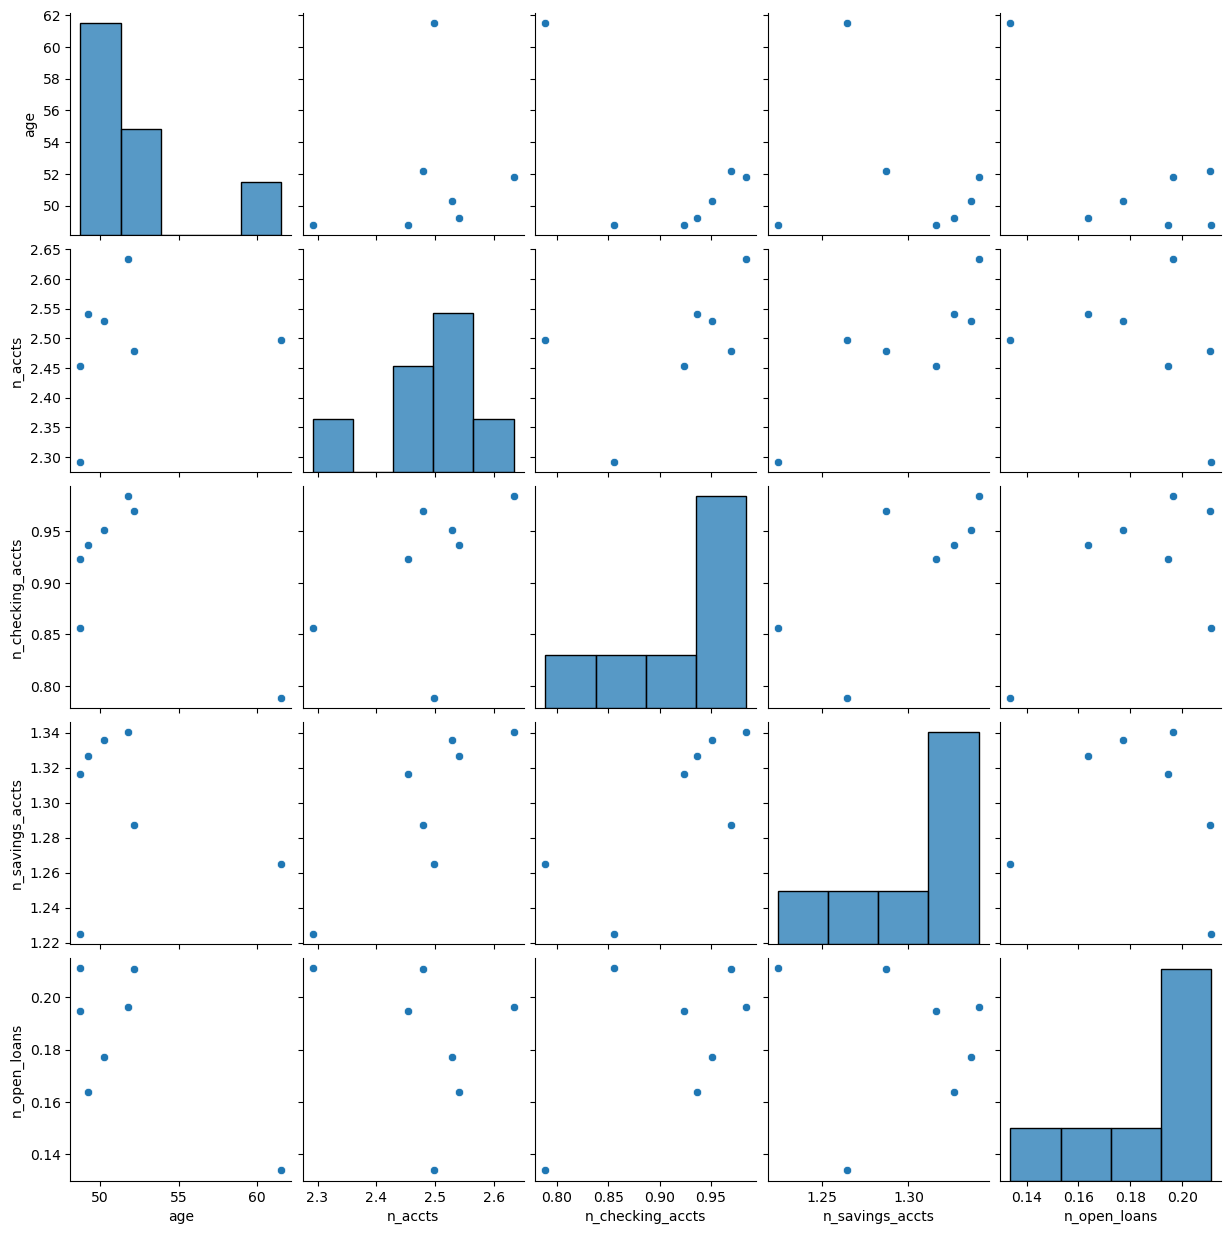

In [19]:
import seaborn as sns

# Plot the data
sns.pairplot(data_for_clustering.iloc[:, 0:5])

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(data_for_clustering)
normalized_df = pd.DataFrame(normalized_df, columns=data_for_clustering.columns)
normalized_df.columns = [col + '_norm' for col in normalized_df.columns]
normalized_df.index = data_for_clustering.index
normalized_df.head()

,age_norm,n_accts_norm,n_checking_accts_norm,n_savings_accts_norm,n_open_loans_norm,n_open_cds_norm,n_open_club_accts_norm,n_open_credit_cards_norm,ATMCount_norm,BillPaymentCount_norm,CashCount_norm,DraftCount_norm,ACHCount_norm,FeeCount_norm,Credit_DebitCount_norm,Home_Banking_norm,WireCount_norm,DividendCount_norm
County,,,,,,,,,,,,,,,,,,
Brevard,1.000,0.602,0.000,0.346,0.000,1.000,0.139,0.066,0.000,0.000,0.000,0.000,0.000,0.049,0.000,0.000,1.000,1.000
Lake,0.236,1.000,1.000,1.000,0.811,0.460,0.115,1.000,0.616,0.640,0.544,0.750,0.643,0.000,0.852,0.667,0.280,0.868
Orange,0.036,0.730,0.758,0.879,0.388,0.174,1.000,0.472,0.727,0.345,0.658,0.181,0.505,0.084,0.704,0.605,0.349,0.848
Osceola,0.000,0.474,0.688,0.790,0.787,0.062,0.225,0.471,0.651,0.507,0.557,0.152,0.650,0.164,0.971,0.840,0.159,0.468
Polk,0.000,0.000,0.343,0.000,1.000,0.000,0.499,0.000,0.980,0.256,1.000,0.344,0.075,1.000,0.787,1.000,0.313,0.000


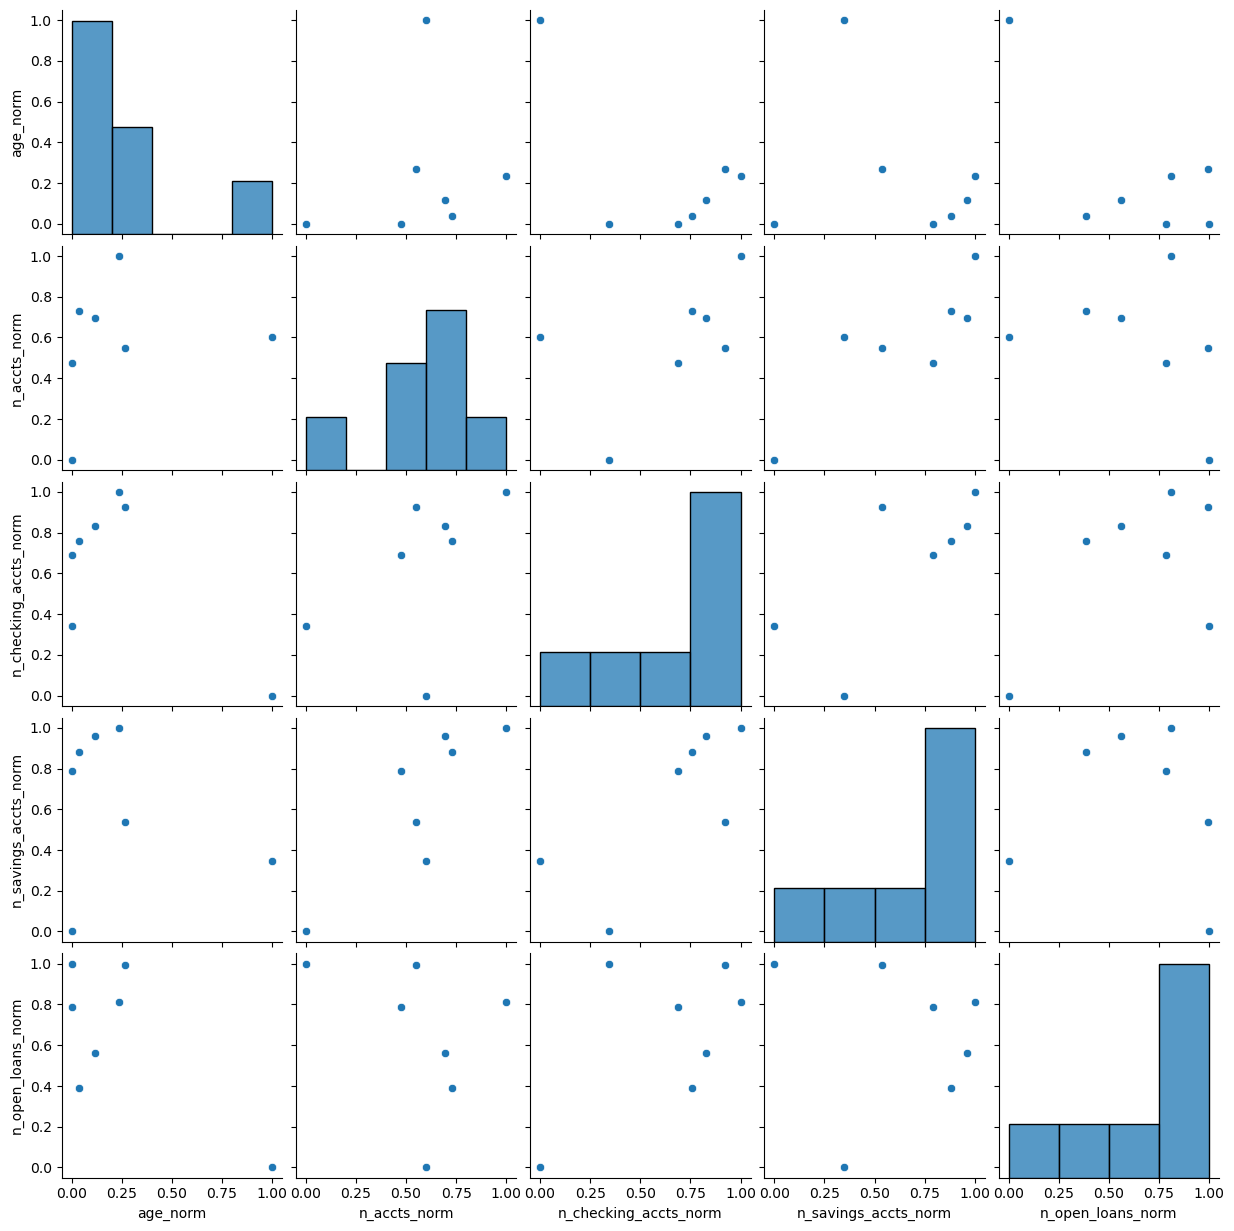

In [21]:
sns.pairplot(normalized_df.iloc[:, 0:5])

# County Clustering

Running KMeans:   0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Running KMeans:  14%|█▍        | 1/7 [00:00<00:03,  1.70it/s]c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Running KMeans:  29%|██▊       | 2/7 [00:01<00:02,  1.86it/s]c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
Running KMeans

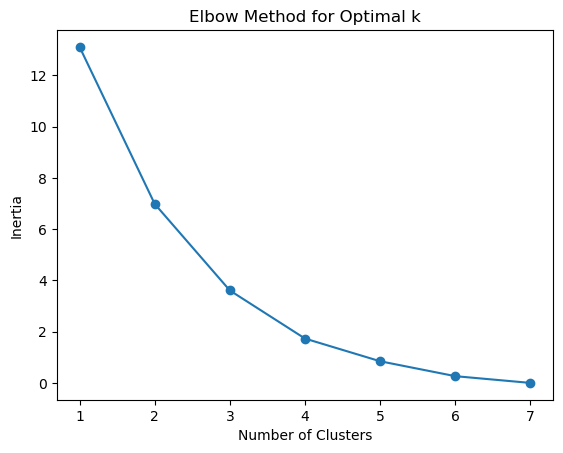

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from tqdm import tqdm

inertias = []

# Use tqdm to add a progress bar
for i in tqdm(range(1, 8), desc="Running KMeans"):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(normalized_df)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 8), inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
print(inertias)

[13.105341852170085, 6.980553995241766, 3.6050205125827253, 1.7296409866483629, 0.8445168124018225, 0.263069644039603, 0.0]


* The optimal number of clusters is 3

In [ ]:
# KMeans Clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans.fit(normalized_df)

c:\Users\perez\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, n_init=10, random_state=0)

In [ ]:
# Cluster labels and county names
cluster_df = normalized_df.copy()
cluster_df['Cluster'] = kmeans.labels_
cluster_df.head()

,age_norm,n_accts_norm,n_checking_accts_norm,n_savings_accts_norm,n_open_loans_norm,n_open_cds_norm,n_open_club_accts_norm,n_open_credit_cards_norm,ATMCount_norm,BillPaymentCount_norm,CashCount_norm,DraftCount_norm,ACHCount_norm,FeeCount_norm,Credit_DebitCount_norm,Home_Banking_norm,WireCount_norm,DividendCount_norm,Cluster
County,,,,,,,,,,,,,,,,,,,
Brevard,1.000,0.602,0.000,0.346,0.000,1.000,0.139,0.066,0.000,0.000,0.000,0.000,0.000,0.049,0.000,0.000,1.000,1.000,2
Lake,0.236,1.000,1.000,1.000,0.811,0.460,0.115,1.000,0.616,0.640,0.544,0.750,0.643,0.000,0.852,0.667,0.280,0.868,0
Orange,0.036,0.730,0.758,0.879,0.388,0.174,1.000,0.472,0.727,0.345,0.658,0.181,0.505,0.084,0.704,0.605,0.349,0.848,0
Osceola,0.000,0.474,0.688,0.790,0.787,0.062,0.225,0.471,0.651,0.507,0.557,0.152,0.650,0.164,0.971,0.840,0.159,0.468,0
Polk,0.000,0.000,0.343,0.000,1.000,0.000,0.499,0.000,0.980,0.256,1.000,0.344,0.075,1.000,0.787,1.000,0.313,0.000,1


In [ ]:
# Names of the counties in each cluster
for i in range(3):
    print(f'Cluster {i}:')
    print(cluster_df[cluster_df['Cluster'] == i].index.values)
    print()

Cluster 0:
['Lake' 'Orange' 'Osceola' 'Seminole' 'Volusia']

Cluster 1:
['Polk']

Cluster 2:
['Brevard']



# PCA Visualization
## 2 Dimensional PCA

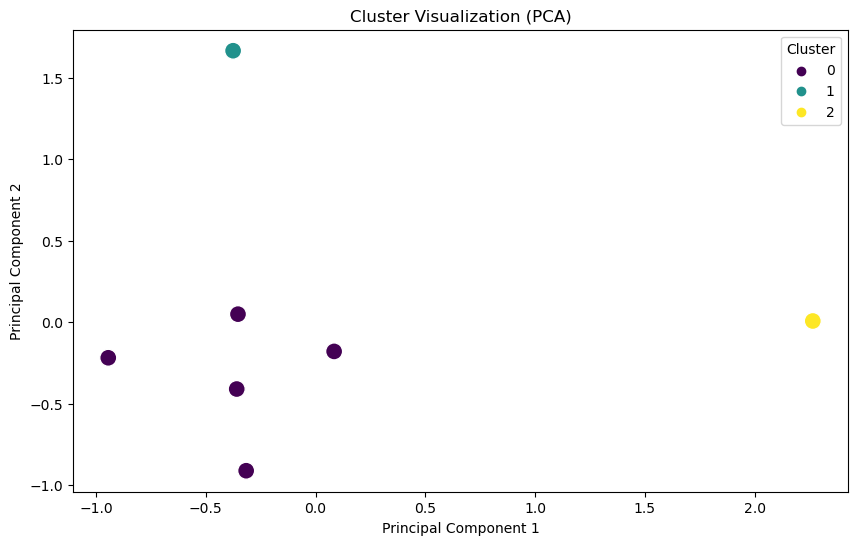

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# Assuming 'Cluster' is the column with cluster labels
clusters = cluster_df['Cluster']

# Extract features for PCA
features = cluster_df.drop('Cluster', axis=1)

# Apply PCA to reduce to 2 dimensions (you can choose a different number)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

# Create a DataFrame with the reduced dimensions and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df.index = features.index
pca_df['Cluster'] = clusters

# Scatter plot with color-coded clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', legend='full', s=150)
plt.title('Cluster Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [ ]:
# Get the feature loadings for PC1 and PC2
loadings_df = pd.DataFrame(pca.components_, columns=features.columns, index=['PC1', 'PC2'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

Feature Loadings for PC1:
n_open_cds_norm             0.296
age_norm                    0.291
DividendCount_norm          0.208
WireCount_norm              0.171
n_accts_norm                0.027
n_open_club_accts_norm     -0.009
n_savings_accts_norm       -0.091
FeeCount_norm              -0.091
n_open_credit_cards_norm   -0.203
DraftCount_norm            -0.230
CashCount_norm             -0.246
ACHCount_norm              -0.249
BillPaymentCount_norm      -0.249
n_checking_accts_norm      -0.275
ATMCount_norm              -0.303
Home_Banking_norm          -0.309
n_open_loans_norm          -0.310
Credit_DebitCount_norm     -0.316
Name: PC1, dtype: float64

Feature Loadings for PC2:
FeeCount_norm               0.411
CashCount_norm              0.172
Home_Banking_norm           0.122
n_open_loans_norm           0.116
ATMCount_norm               0.107
n_open_club_accts_norm      0.099
WireCount_norm              0.002
Credit_DebitCount_norm     -0.019
age_norm                   -0.083
n_o

## 3 Dimensional PCA

In [ ]:
# Now apply PCA to reduce to 3 dimensions
pca = PCA(n_components=3)
principal_components = pca.fit_transform(features)

# Create a DataFrame with the reduced dimensions and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
pca_df.index = features.index
pca_df['Cluster'] = clusters

# Set Cluster to categorical
pca_df['Cluster'] = pca_df['Cluster'].astype('category')

# 3D scatter plot with color-coded clusters
fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color='Cluster', opacity=0.7, size_max=10, labels={'Cluster': 'Cluster'},
                    width=1100, height=800, color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.update_layout(legend_title_text='County', legend=dict(yanchor="top", y=0.79, xanchor="left", x=0.01))
fig.show()

In [ ]:
# Get the feature loadings for PC1, PC2, and PC3
loadings_df = pd.DataFrame(pca.components_, columns=features.columns, index=['PC1', 'PC2', 'PC3'])

# Display the feature loadings
print("Feature Loadings for PC1:")
print(loadings_df.loc['PC1'].sort_values(ascending=False))

print("\nFeature Loadings for PC2:")
print(loadings_df.loc['PC2'].sort_values(ascending=False))

print("\nFeature Loadings for PC3:")
print(loadings_df.loc['PC3'].sort_values(ascending=False))

Feature Loadings for PC1:
n_open_cds_norm             0.296
age_norm                    0.291
DividendCount_norm          0.208
WireCount_norm              0.171
n_accts_norm                0.027
n_open_club_accts_norm     -0.009
n_savings_accts_norm       -0.091
FeeCount_norm              -0.091
n_open_credit_cards_norm   -0.203
DraftCount_norm            -0.230
CashCount_norm             -0.246
ACHCount_norm              -0.249
BillPaymentCount_norm      -0.249
n_checking_accts_norm      -0.275
ATMCount_norm              -0.303
Home_Banking_norm          -0.309
n_open_loans_norm          -0.310
Credit_DebitCount_norm     -0.316
Name: PC1, dtype: float64

Feature Loadings for PC2:
FeeCount_norm               0.411
CashCount_norm              0.172
Home_Banking_norm           0.122
n_open_loans_norm           0.116
ATMCount_norm               0.107
n_open_club_accts_norm      0.099
WireCount_norm              0.002
Credit_DebitCount_norm     -0.019
age_norm                   -0.083
n_o